# Exploración de datos

Notebook para explorar los datos previavemente procesados y almacenados en *data_processed/data_processed.csv* 

Para obtener este dataset se utilizaron los notebooks que se encuentran en la carpeta *Extraccion_datos*.

1) Definición de cada atributo y sus características

2) Visualización

3) Estudio de correlaciones

4) Identificar mejoras a aplicar a los datos (transformaciones, datos extra, etc.). Conclusiones.

In [25]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('../data_processed/data_processed.csv',sep=';',index_col=False,parse_dates=['FECHA'])

In [3]:
pd.options.display.max_columns= None

In [4]:
df.head()

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
0,2015-10-01,1,10,4,56.65,0,0,2196.1,24517.1,10060.7,7181.4,22,3714,4909,1
1,2015-10-01,2,10,4,53.50,0,0,2064.4,23168.6,10060.7,6771.7,22,3714,4909,0
2,2015-10-01,3,10,4,49.69,0,0,1866.5,22437.2,10060.7,6559.5,22,3714,4909,0
3,2015-10-01,4,10,4,49.10,0,0,1660.9,22281.3,10060.7,6560.4,23,3714,4909,0
4,2015-10-01,5,10,4,51.25,0,0,1373.9,21909.7,10060.7,6724.1,23,3714,4909,0


In [5]:
df.describe()

,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA
count,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000,26301.000000
mean,12.501084,6.522300,4.080871,48.740019,0.247557,0.575073,5479.385506,28674.013003,8607.388400,4413.024957,13.704726,4627.927265,4154.811300,0.575567
std,6.921969,3.449043,2.020287,14.955317,0.431601,0.494341,3186.007150,4615.766551,745.633807,2218.821169,6.263835,1464.006360,1303.402024,0.494266
min,1.000000,1.000000,1.000000,2.060000,0.000000,0.000000,240.800000,17728.400000,5693.700000,546.000000,2.000000,2222.000000,2138.000000,0.000000
25%,7.000000,4.000000,2.000000,40.140000,0.000000,0.000000,3018.400000,24735.700000,8120.400000,2317.100000,8.000000,3429.000000,3137.000000,0.000000
50%,13.000000,7.000000,4.000000,49.550000,0.000000,1.000000,4822.700000,28921.700000,8679.100000,4636.600000,15.000000,4545.000000,4266.000000,1.000000
75%,19.000000,10.000000,6.000000,59.450000,0.000000,1.000000,7289.700000,32268.100000,9153.600000,6290.700000,19.000000,5726.000000,5004.000000,1.000000
max,24.000000,12.000000,7.000000,101.990000,1.000000,1.000000,16952.600000,41297.900000,10070.400000,8768.300000,25.000000,7105.000000,6472.000000,1.000000


In [6]:
df.dtypes

FECHA               datetime64[ns]
PERIODO                      int64
MES                          int64
WD                           int64
PRECIO_MD_ESP              float64
ACOPLADO_FR                  int64
RESERVA_D-1                  int64
P48_EOLICA                 float64
P48_DEMANDA                float64
POT_DISP_CARBON            float64
P48_CARBON_D-1             float64
NUM_PLANTAS_D-1              int64
EMB_ANUALES                  int64
EMB_HIPERANUALES             int64
RESERVA                      int64
dtype: object

In [7]:
df.isnull().any().any()  #comprobamos, aunque ya estaba testeado, que no hay NaN

False

## 1) Definición de cada atributo:

* **FECHA**: día de estudio. Formato %Y-%m-%d

* **PERIODO**: representa la hora del día expresado como la finalización de la hora de estudio. Es decir, el periodo 1 contiene la información del periodo comprendido entre las 00:00 y las 01:00

* **MES**: mes al que pertenece el día de estudio, de 1 a 12. No todos los meses son iguales. En electricidad se suele simplificar hablando de Qs (trimestres). Así, el Q1 que comprende los meses de enero, febrero y marzo, se suelen caracterizar por alta eolicidad, demanda (invierno), hidraulicidad, mientras que en los meses del Q3, julio, agosto, septiembre, la eolicidad es más baja, desciende la aportación hidráulica, etc. Es por ello que se ha seleccionado el mes como una de las características a tener en cuenta.

### El target es RESERVA: 

* 0 = Sube el intradiario, compro todo en el MD.

* 1 = Baja el intradiario, reservo parte de mi compra para comprarla más barata en el MI1.

Lo primero compruebo si los datos están desbalanceados o si tiene alguna tendencia temporal:

In [8]:
df['RESERVA'].value_counts(normalize=True)

1    0.575567
0    0.424433
Name: RESERVA, dtype: float64

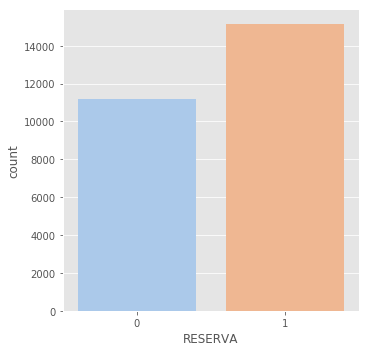

In [9]:
#Para usar sns.catplot es necesario contar con la última actualización de seaborn: v0.9.0

#conda update seaborn

sns.catplot('RESERVA',data=df,kind="count",palette="pastel")
plt.show()

Aunque hay más horas donde baja el intradiario, está bastante equilibrado.

Compruebo si existe desbalanceado entre 1 año y otro. Me ayudo de 3 dataset distintos, cada uno un año hidráulico, y añado columna anho que representa el año hidráulico al que pertenecen:

*NOTA: El año hidráulico comienza en octubre y finaliza en septiembre, por considerarse octubre el primer mes de lluvias. Por ello nuestro dataset se inició en octubre 2015.*

In [10]:
df_anho=df.copy()  #Creamos copia de df

In [11]:
anho=pd.to_datetime(['2016-10-01','2017-10-01','2018-10-01'],format='%Y-%m-%d')
anho  #límite del año hidraúlico

DatetimeIndex(['2016-10-01', '2017-10-01', '2018-10-01'], dtype='datetime64[ns]', freq=None)

In [12]:
df_anho_2016=df[df['FECHA']<anho[0]]
df_anho_2017=df[(df['FECHA']>=anho[0])&(df['FECHA']<anho[1])]
df_anho_2018=df[(df['FECHA']>=anho[1])]

In [13]:
#Función para crear año hidráulico
def anho_hidraulico(elem):
    if elem<anho[0]:
        return 1;
    elif elem<anho[1]:
        return 2;
    else:
        return 3;

In [14]:
df_anho['ANHO']=list(df_anho['FECHA'].map(anho_hidraulico))
df_anho.sample(10)  #Comprobamos correcto funcionamiento:

,FECHA,PERIODO,MES,WD,PRECIO_MD_ESP,ACOPLADO_FR,RESERVA_D-1,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,P48_CARBON_D-1,NUM_PLANTAS_D-1,EMB_ANUALES,EMB_HIPERANUALES,RESERVA,ANHO
8391,2016-09-14,17,9,3,41.00,0,0,8130.5,30505.1,8314.8,6053.0,19,3765,4778,1,1
19494,2017-12-21,9,12,4,70.91,1,1,5614.1,35456.3,9181.7,8616.1,24,2617,2267,1,3
12179,2017-02-19,13,2,7,46.07,1,1,5400.5,27220.3,8040.8,5840.2,18,4613,3588,1,2
9700,2016-11-08,6,11,2,45.95,1,0,8840.8,22984.3,7969.5,5058.2,20,3472,4266,1,2
8815,2016-10-02,9,10,7,40.37,0,0,1214.2,20698.5,7519.2,5529.4,17,3148,4491,0,2
4452,2016-04-03,14,4,7,13.48,1,1,10861.3,26678.5,8523.5,1013.5,4,6841,6339,0,1
6375,2016-06-22,17,6,3,33.53,0,1,7085.8,32647.5,8428.9,3496.2,11,6557,6194,0,1
25468,2018-08-27,8,8,1,64.69,0,1,2931.7,27468.8,9495.0,3318.8,11,5172,4143,1,3
14902,2017-06-13,1,6,2,47.13,0,0,6424.9,28594.5,8182.7,3785.1,12,4572,2932,1,2
9605,2016-11-04,7,11,5,61.99,0,0,3423.9,25346.2,8089.2,6766.9,21,3472,4266,0,2


**Tabla de contingencia en porcentajes relativos año hidráulico/Reserva**

In [16]:
pd.crosstab(index=df_anho['RESERVA'],columns=df_anho['ANHO'],margins=True).apply(lambda x: x/len(df_anho)*100,axis=1)

ANHO,1,2,3,All
RESERVA,,,,
0,13.950040,14.820729,13.672484,42.443253
1,19.444128,18.482187,19.630432,57.556747
All,33.394168,33.302916,33.302916,100.000000


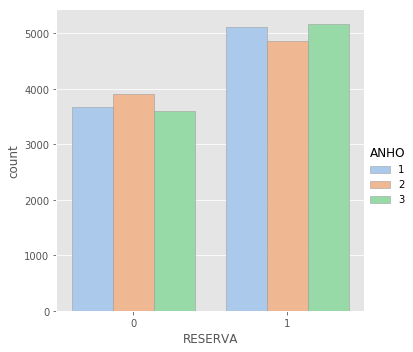

In [17]:
sns.catplot("RESERVA", hue="ANHO", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_anho);

Se concluye que por años tampoco esta balanceado ¿Por meses?

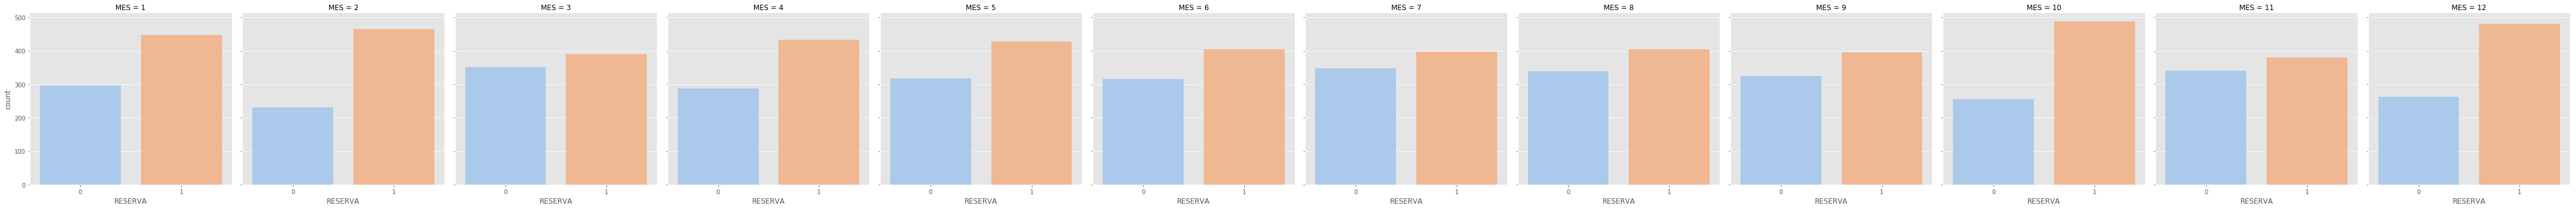

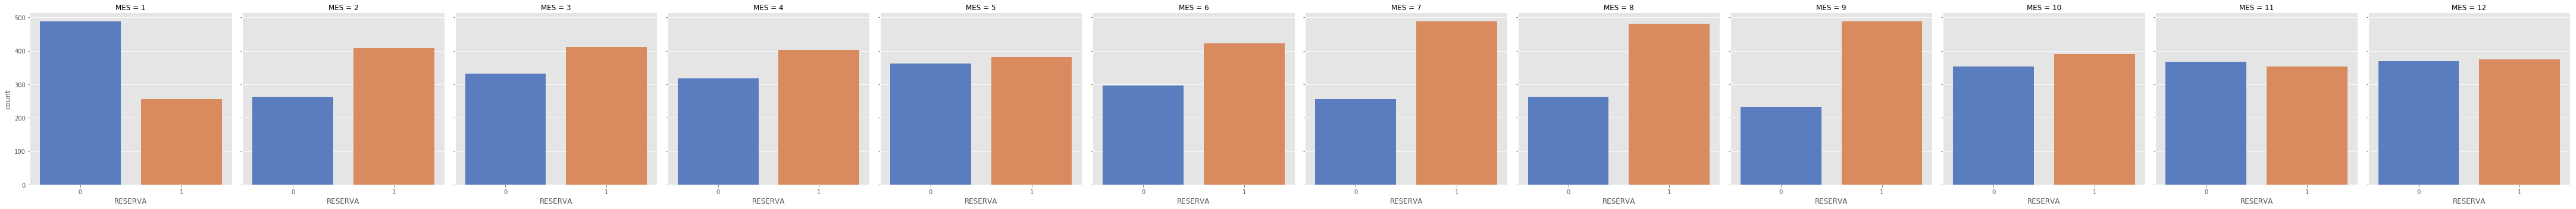

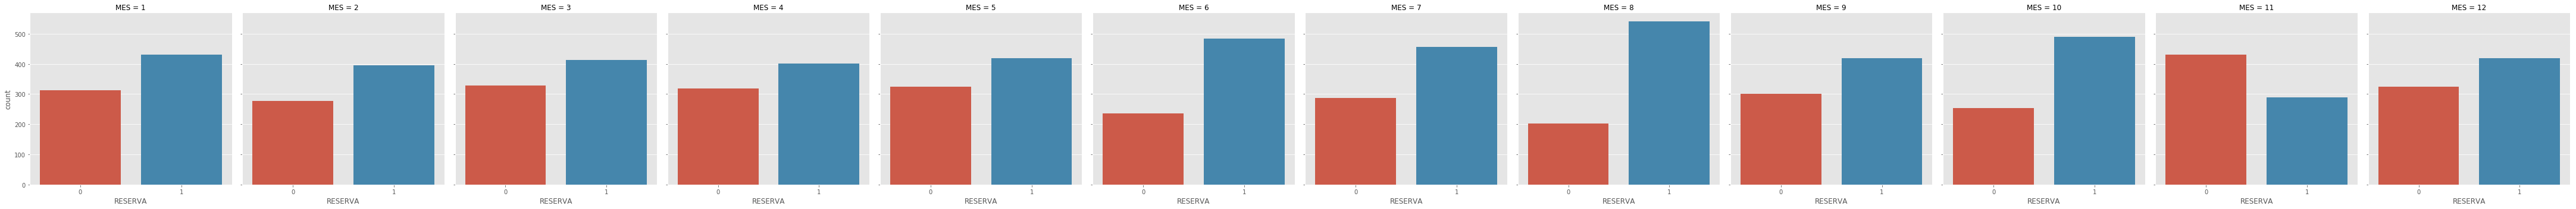

In [18]:
sns.catplot('RESERVA',data=df_anho_2016,kind="count",col="MES",palette="pastel");
sns.catplot('RESERVA',data=df_anho_2017,kind="count",col="MES",palette="muted");
sns.catplot('RESERVA',data=df_anho_2018,kind="count",col="MES");

In [19]:
pd.crosstab(index=df_anho['RESERVA'],columns=df_anho['MES'],margins=True).apply(lambda x: x/len(df_anho)*100,axis=1)

MES,1,2,3,4,5,6,7,8,9,10,11,12,All
RESERVA,,,,,,,,,,,,,
0,4.174746,2.927645,3.847762,3.509372,3.817345,3.224212,3.383902,3.060720,3.258431,3.277442,4.326832,3.634843,42.443253
1,4.311623,4.828714,4.627200,4.703243,4.669024,4.988403,5.102468,5.425649,4.954184,5.208927,3.885784,4.851527,57.556747
All,8.486369,7.756359,8.474963,8.212615,8.486369,8.212615,8.486369,8.486369,8.212615,8.486369,8.212615,8.486369,100.000000


No se observa un desbalanceo de los datos en el conjunto del año .

Hay meses donde sí se ha dado más un caso que otro *(oct15,feb16,ene17,sept17,junio18...)*, sin un patrón claro. 

**DUDA: ¿Es el mes una feature a considerar en el modelo?**

**Haré la validación del modelo n veces para ajustar los hiperparámetros y evitar perder muestras importantes (cross-validation)**

Estudio de otras variables como la laboralidad **(WD)**:

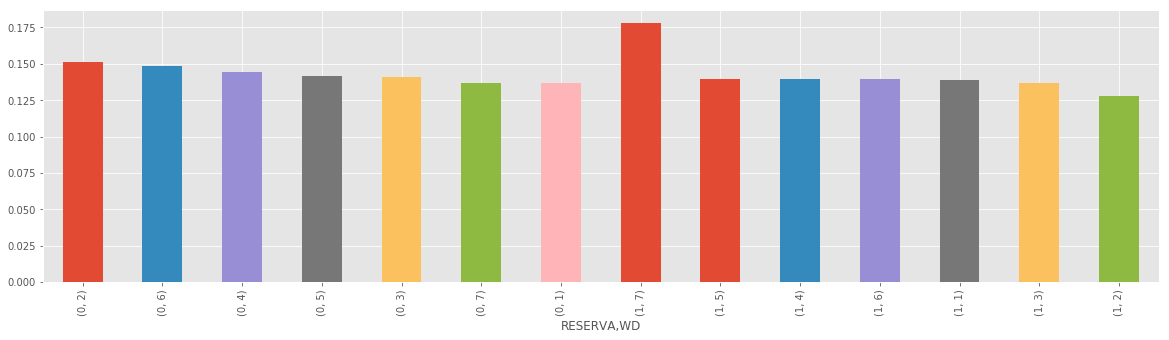

In [26]:
df_anho.groupby('RESERVA')['WD'].value_counts(normalize=True).plot(kind='bar');

Los domingos/festivos se observa en los 3 años mayor porcentaje de horas con bajada de precio en el mercado intradiario.

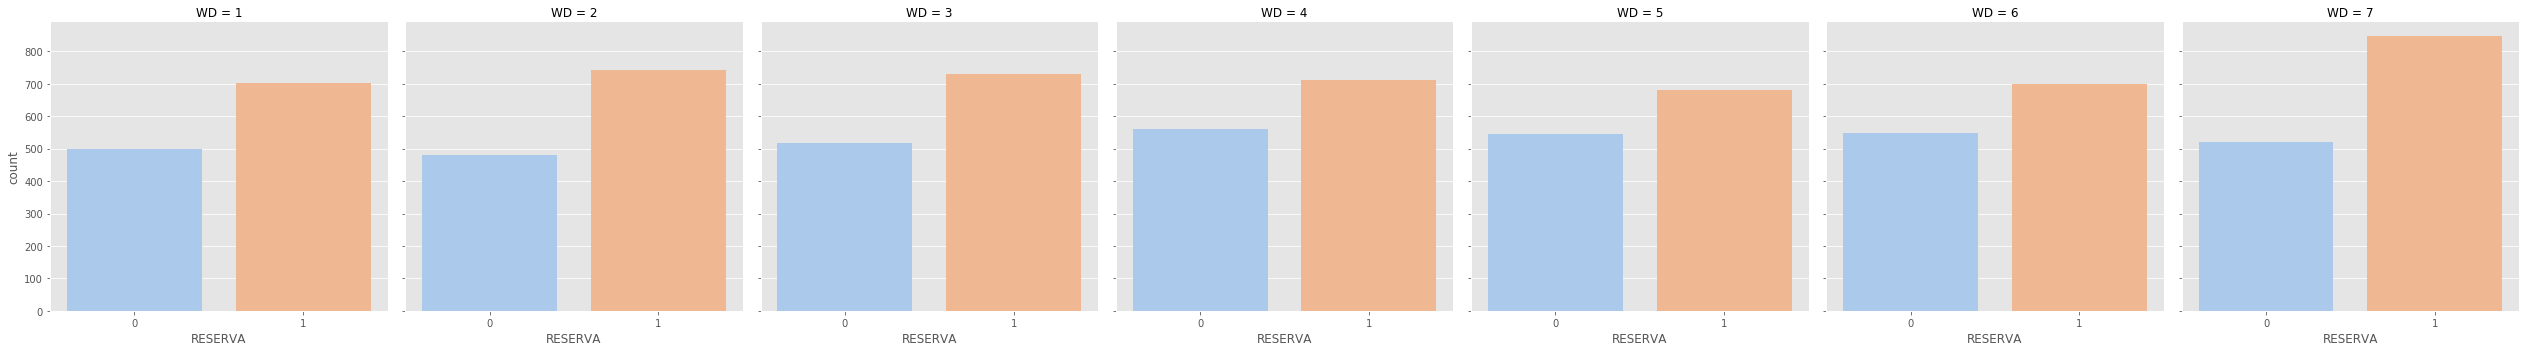

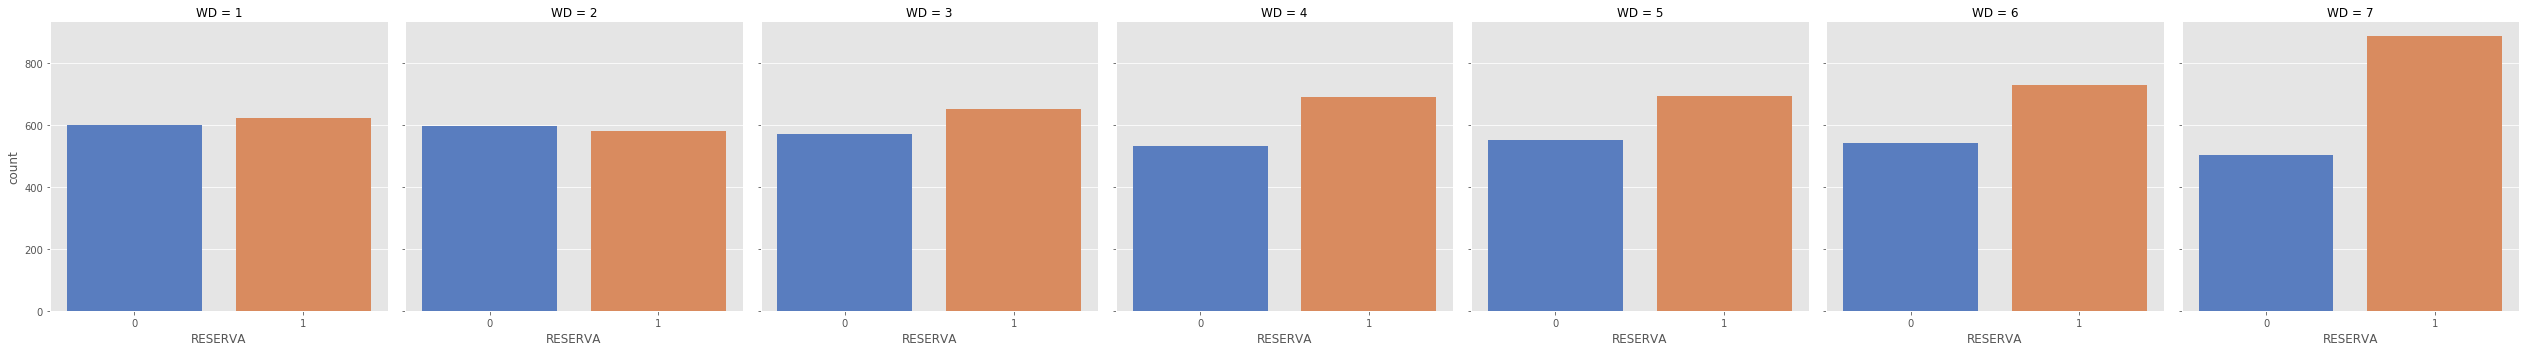

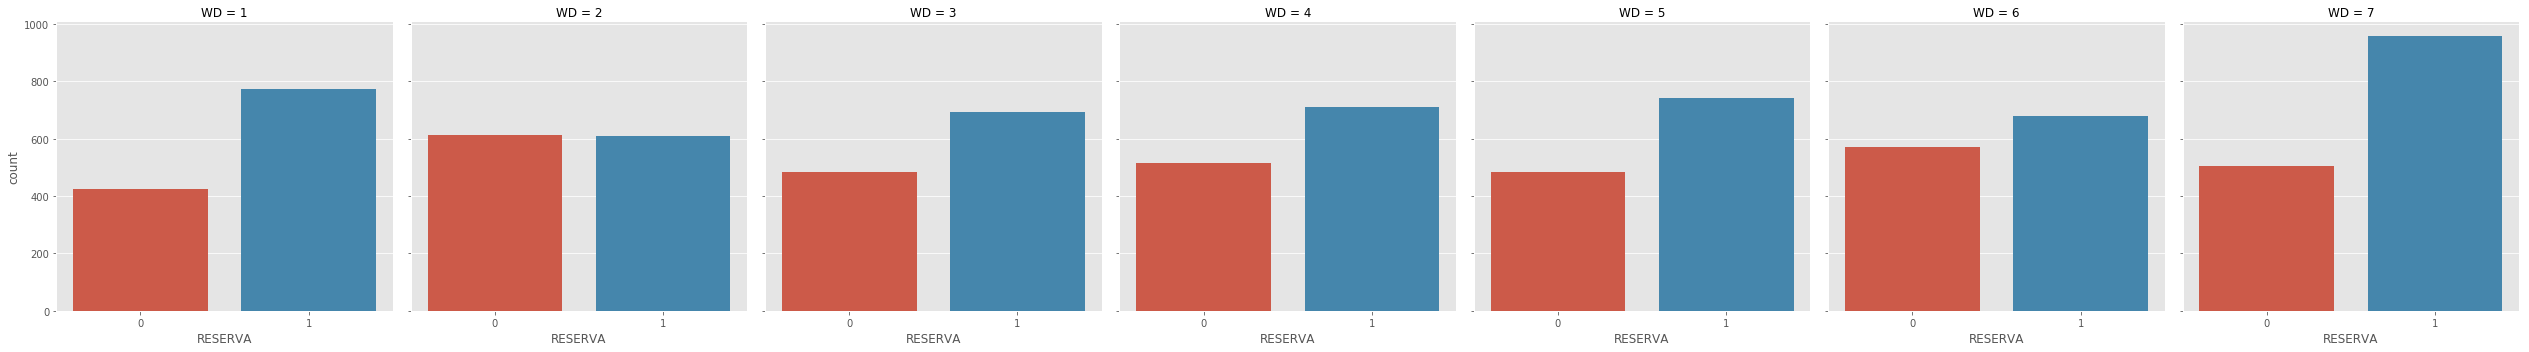

In [27]:
sns.catplot('RESERVA',data=df_anho_2016,kind="count",col="WD",palette="pastel");
sns.catplot('RESERVA',data=df_anho_2017,kind="count",col="WD",palette="muted");
sns.catplot('RESERVA',data=df_anho_2018,kind="count",col="WD");

### ¿Es correcto, a priori, utilizar un dataset de 3 años?

Analizo cómo se comportaron las distintas variables cada año, para valorar si con 3 años se consigue abarcar diferentes escenarios que se puedan presentar en el futuro o si con un dataset más pequeño sería suficiente.

Además, agrupo por dato mensual para evaluar si es correcto utilizarlo como *feature* o va intrínseco en el comportamiento del resto de variables.

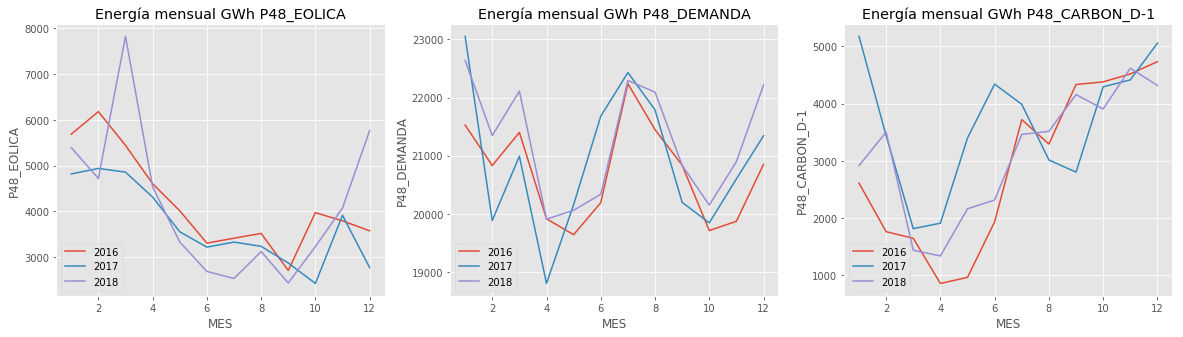

In [28]:
#Divido entre 1000 para expresarlo en GWh mensuales
df_mensual_2016=df_anho_2016[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES').sum()/1000
df_mensual_2017=df_anho_2017[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES').sum()/1000
df_mensual_2018=df_anho_2018[['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1','MES']].groupby('MES').sum()/1000

for i,col in enumerate(['P48_EOLICA','P48_DEMANDA','P48_CARBON_D-1']):
    plt.subplot(1,3,i+1)
    plt.title("Energía mensual GWh " + col) 
    plt.plot(df_mensual_2016[col],label='2016')
    plt.plot(df_mensual_2017[col],label='2017')
    plt.plot(df_mensual_2018[col],label='2018')
    plt.legend(loc="lower left")
    plt.xlabel("MES")    
    plt.ylabel(col)   
plt.show()


De momento sí se observa un perfil mensual en el comportamiento de las variables estudiadas, por lo que podría no ser necesario incluir el mes en el modelo clasificador que se escoja.

Sin embargo, aunque este comportamiento es análogo cada año en cuanto a perfil, el nivel de producción varía considerablemente de un año a otro algunos meses. **De momento decido quedarme con los 3 años**

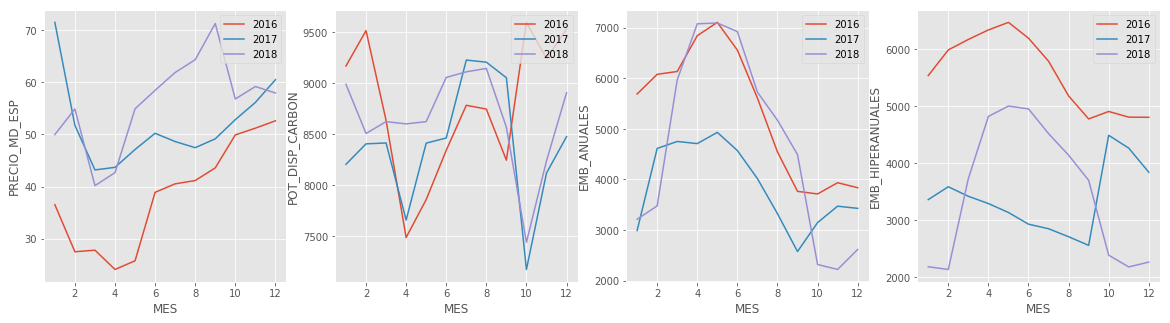

In [29]:
df_mensual_2016_2=df_anho_2016[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES').mean()
df_mensual_2017_2=df_anho_2017[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES').mean()
df_mensual_2018_2=df_anho_2018[['POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES','PRECIO_MD_ESP','MES']].groupby('MES').mean()

for i,col in enumerate(['PRECIO_MD_ESP','POT_DISP_CARBON','EMB_ANUALES','EMB_HIPERANUALES']):
    plt.subplot(1,4,i+1)
    plt.plot(df_mensual_2016_2[col],label='2016')
    plt.plot(df_mensual_2017_2[col],label='2017')
    plt.plot(df_mensual_2018_2[col],label='2018')
    plt.legend(loc="upper right")
    plt.xlabel("MES")    
    plt.ylabel(col)   
plt.show()

* La **Potencia Disponible de Carbón** va asociada a las paradas programadas de las plantas. Parece que suelen llevarse a cabo habitualmente en los mismos meses salvo en el último trimestre del 2016.

* Vemos por años como ha variado la situación de los embalses. Se distinguen dos tipos de embalses por ser distinta la disponibilidad de la aportación al mix de generación que tienen. Por ello no se juntan ambas variables en una. Se definen:

    * **Embalses anuales:** Embalses con una capacidad de regulación de sus reservas inferior a un año.
    * **Embalses hiperanuales:** Embalses con una capacidad de regulación de sus reservas superior a un año.

El vaciado y llenado de los embalses, como se corrobora en los gráficos, va muy ligado al mes en el que se encuentra. Por tanto estos datos también recogerían por sí solos información mensual.

En cuanto a cómo han variado en los últimos años, se cogieron 3 años hidráulicos para intentar abarcar situaciones de hidraulicidad distintas: 

2016 tenía un nivel elevado de hidráulica porque partía de años húmedos (2013, 2014 principalmente), pero a final de año comienzan las consecuencias de un año hidráulico seco que continúa durante 2017 y no se recupera hasta marzo de 2018.


* Por último, el **Precio del MD** medio mensual varía mucho de unos meses a otros y de un año a otro. 

### Análisis de la variable PRECIO_MD_ESP

Se analiza esta variable más en profundidad. Posibles outliers y comportamiento de los mismos en cuanto a si después sube o baja el precio en los MMII (columna RESERVA) para tomar decisiones sobre mantenerlos o no.

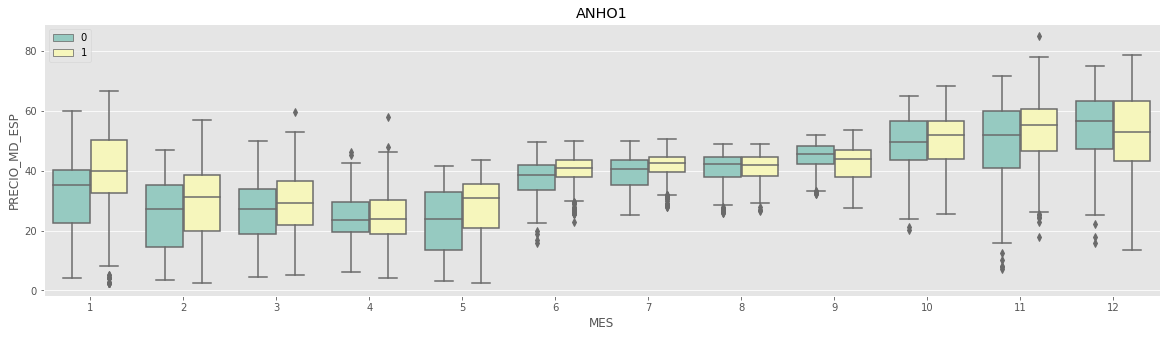

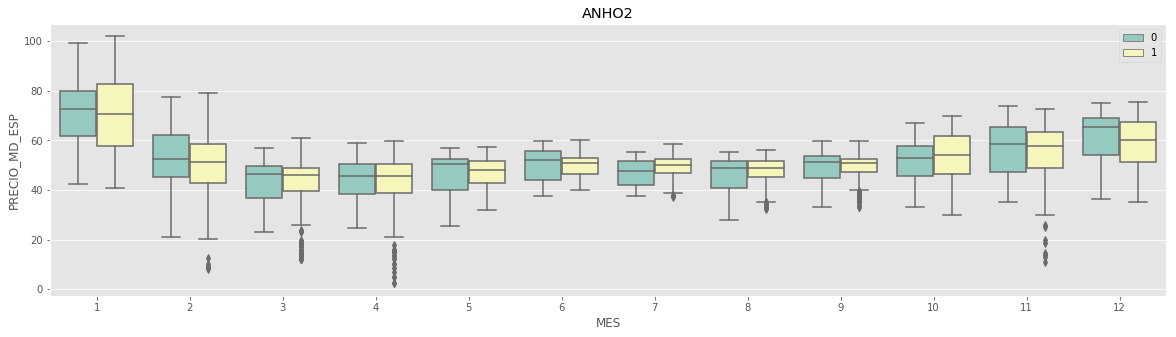

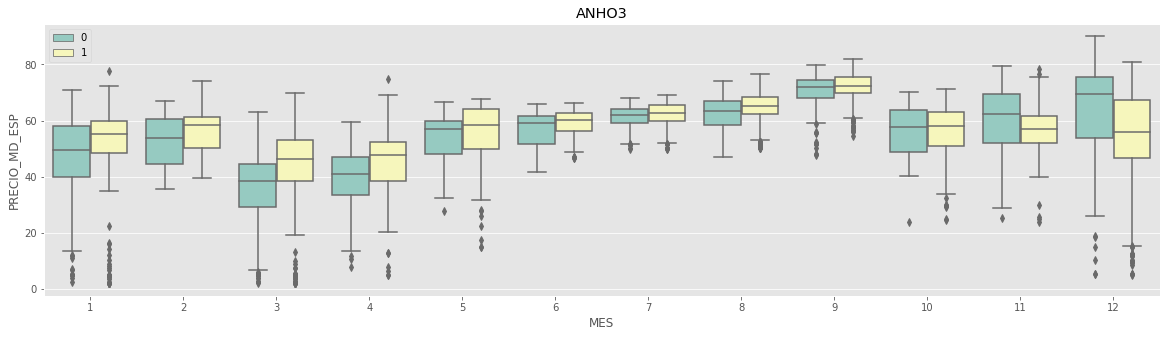

In [30]:
plt.title("ANHO1")
sns.boxplot(x="MES", y="PRECIO_MD_ESP", hue="RESERVA", data=df_anho_2016,palette="Set3")
plt.legend(loc="best")
plt.show()

plt.title("ANHO2")
sns.boxplot(x="MES", y="PRECIO_MD_ESP",hue="RESERVA", data=df_anho_2017,palette="Set3")
plt.legend(loc="best")
plt.show()

plt.title("ANHO3")
sns.boxplot(x="MES", y="PRECIO_MD_ESP", hue="RESERVA",data=df_anho_2018,palette="Set3")
plt.legend(loc="best")
plt.show()

En todos los años parece existir más outliers de precios de MD bajos. Sin embargo, en los gráficos de cajas y bigotes representados, no se aprecia que impliquen una subida o bajada de los MMII directamente. Compruebo si es correcta esta afirmación:

In [31]:
out_2016=df_anho_2016[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.2)

out_2017=df_anho_2017[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.2)

out_2018=df_anho_2018[['PRECIO_MD_ESP','MES']].groupby('MES').quantile(0.2)

In [32]:
df_subset_2016=[]
for k,v in enumerate(df_anho_2016['MES']):
    mes=v
    precio= df_anho_2016['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_2016['RESERVA'].iloc[k]
    if precio < out_2016['PRECIO_MD_ESP'].loc[mes]:
        df_subset_2016.append(reserva)
df_subset_2016=pd.Series(df_subset_2016)

df_subset_2017=[]
for k,v in enumerate(df_anho_2017['MES']):
    mes=v
    precio= df_anho_2017['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_2017['RESERVA'].iloc[k]
    if precio < out_2017['PRECIO_MD_ESP'].loc[mes]:
        df_subset_2017.append(reserva)
df_subset_2017=pd.Series(df_subset_2017)

df_subset_2018=[]
for k,v in enumerate(df_anho_2018['MES']):
    mes=v
    precio= df_anho_2018['PRECIO_MD_ESP'].iloc[k]
    reserva=df_anho_2018['RESERVA'].iloc[k]
    if precio < out_2018['PRECIO_MD_ESP'].loc[mes]:
        df_subset_2018.append(reserva)
df_subset_2018=pd.Series(df_subset_2018)

In [127]:
print(df_subset_2016.value_counts(normalize=True))
print(df_subset_2017.value_counts(normalize=True))
print(df_subset_2018.value_counts(normalize=True))

1    0.520069
0    0.479931
dtype: float64
0    0.517162
1    0.482838
dtype: float64
0    0.527698
1    0.472302
dtype: float64


**Viendo que los outliers de Precios MD no determinan una subida/bajada del MMII por sí solos, los mantengo en el dataset.**

### Estudio de la distribución de las variables

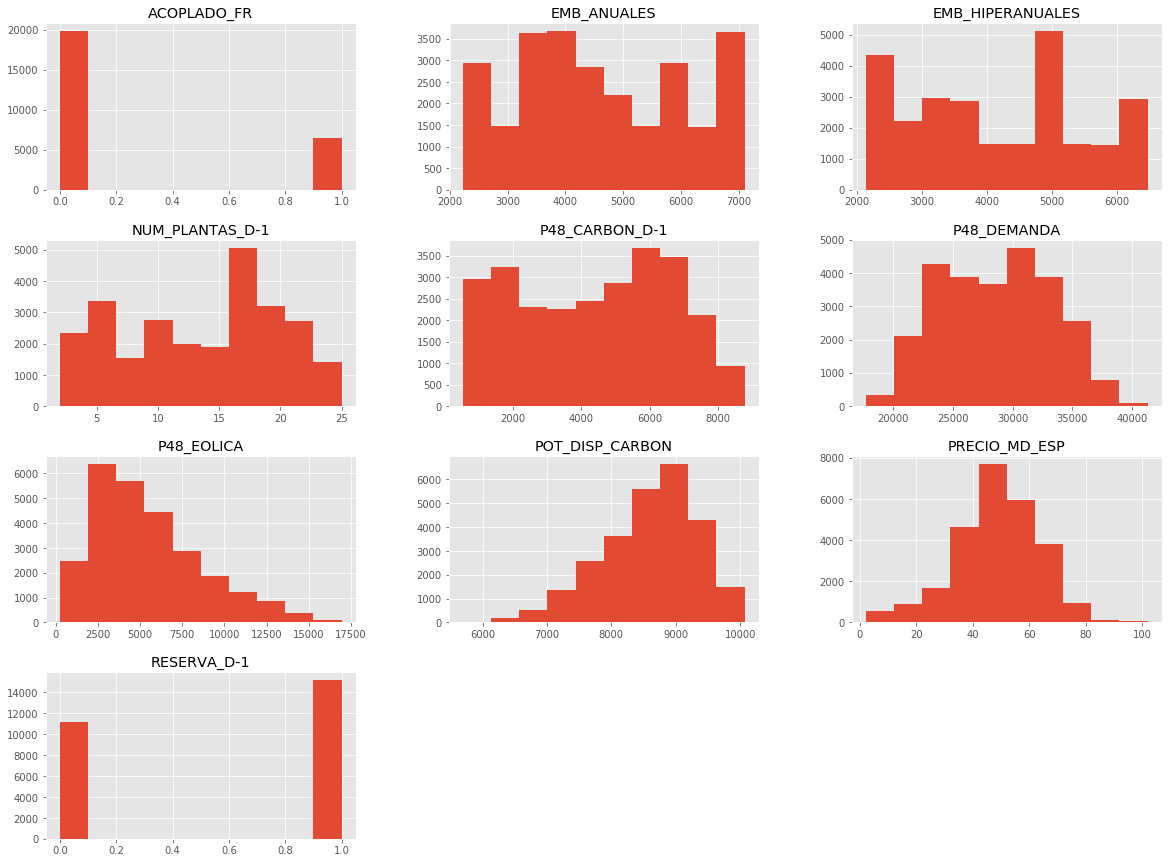

In [33]:
df.drop(['RESERVA','MES','PERIODO','WD'],axis=1).hist(figsize=(20,15))
plt.show()

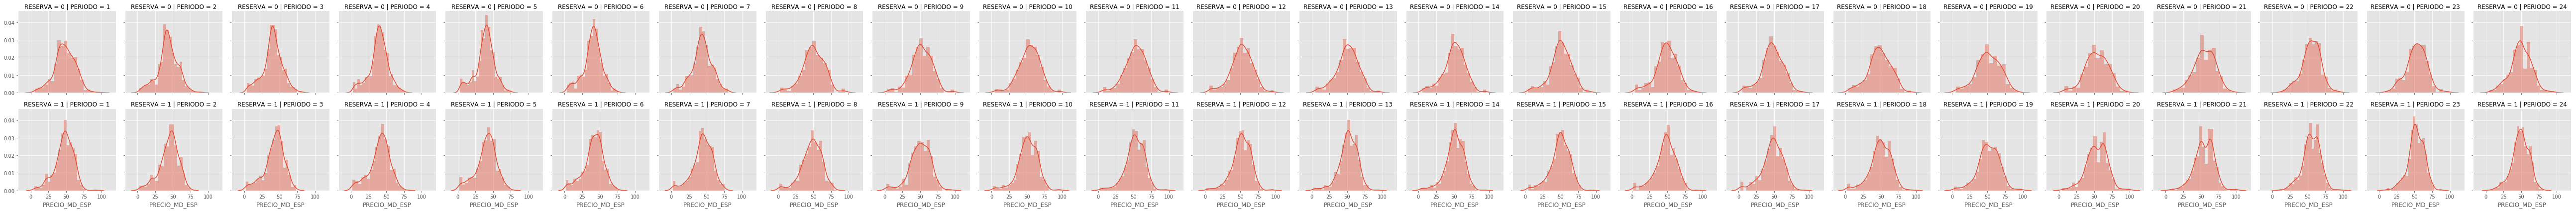

In [36]:
g = sns.FacetGrid(df, col="PERIODO", row="RESERVA")
g.map(sns.distplot, "PRECIO_MD_ESP",kde=True);

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


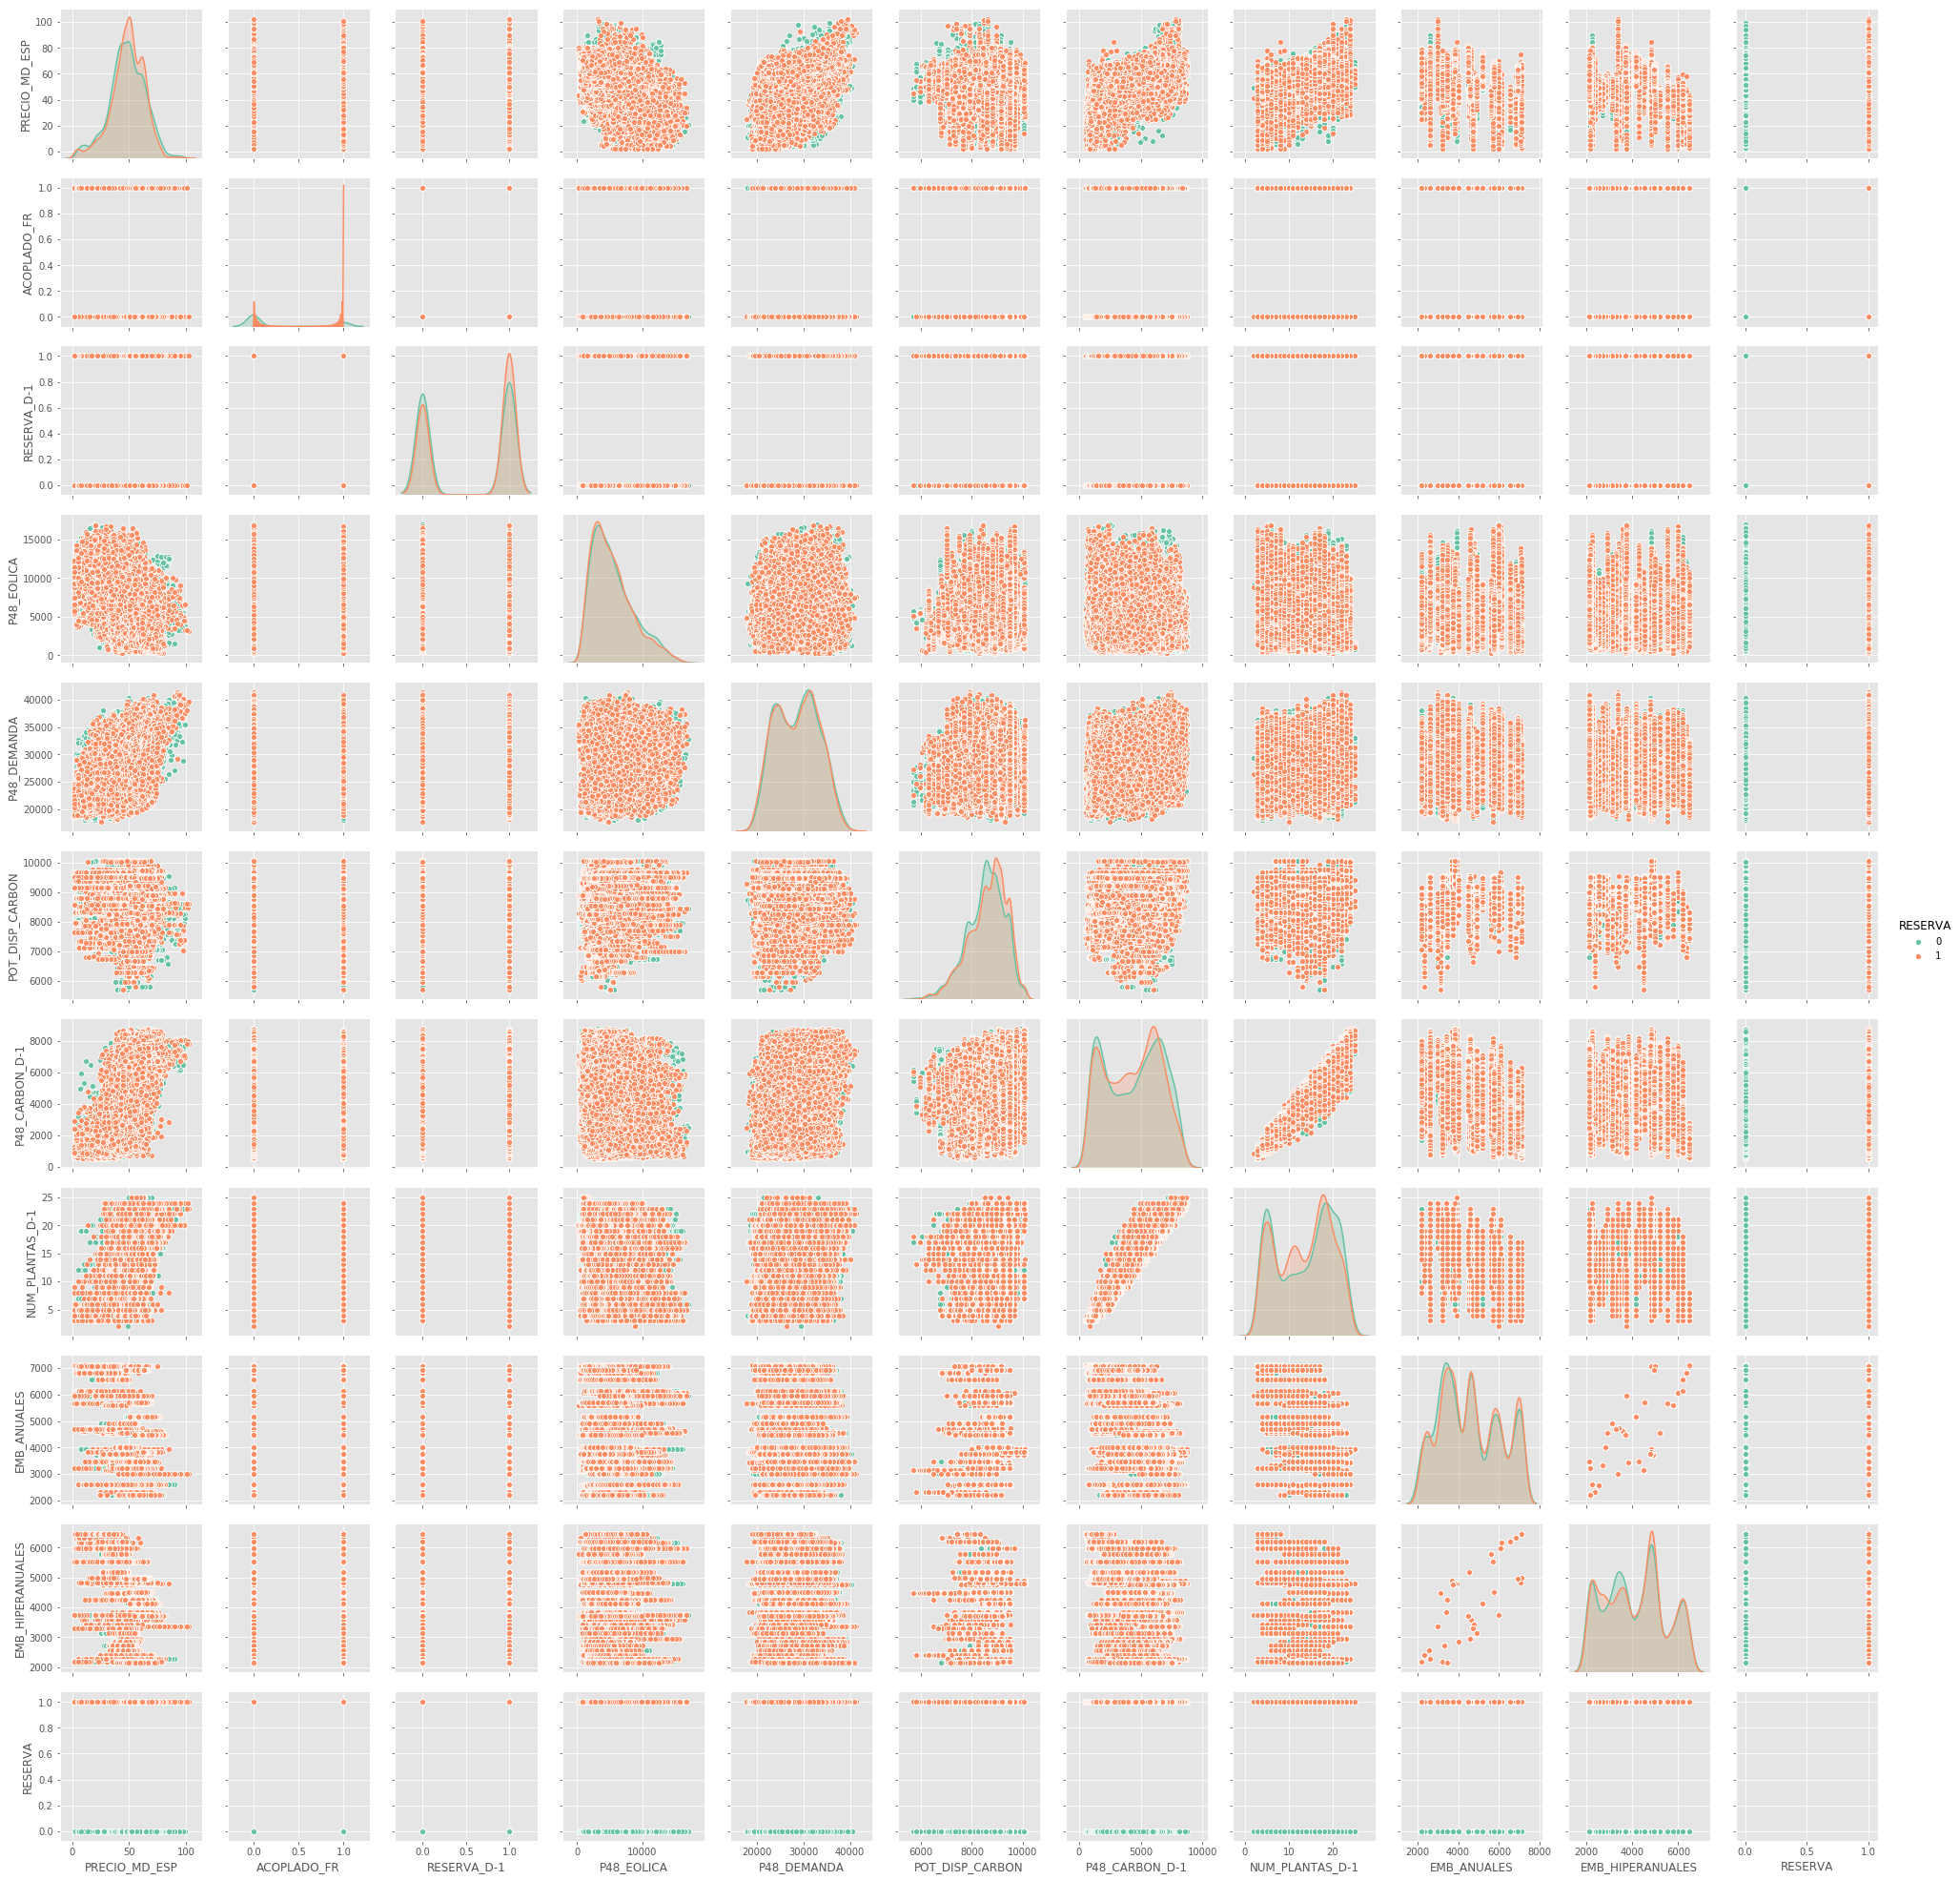

In [41]:
sns.pairplot(df_anho.drop(['MES','PERIODO','ANHO','WD'],axis=1),hue='RESERVA',palette="Set2")
plt.show()

### Estudio correlaciones

In [39]:
correlations=df.corr()

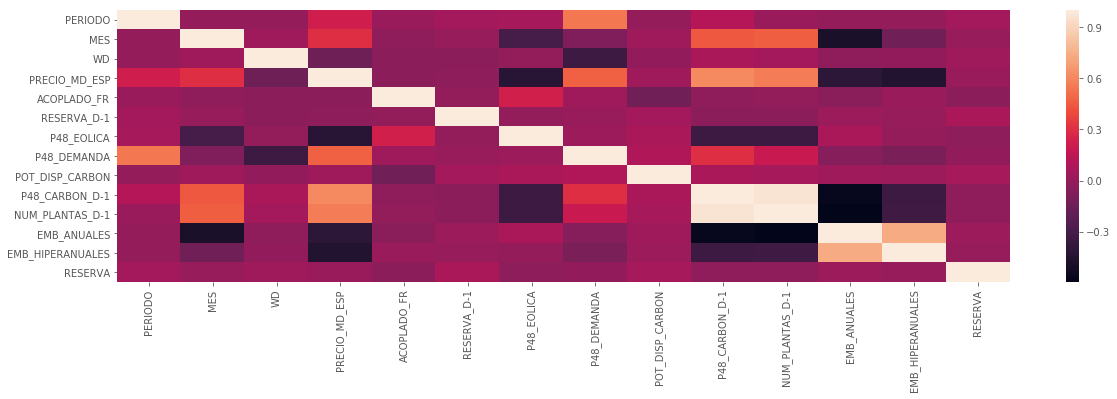

In [42]:
sns.heatmap(data=correlations)
plt.show()